In [1]:
# This notebook runs on Colab
!pip install transformers datasets sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 30.7 MB/s 
     |████████████████████████████████| 432 kB 55.6 MB/s 
     |████████████████████████████████| 1.3 MB 44.8 MB/s 
     |████████████████████████████████| 163 kB 53.2 MB/s 
     |████████████████████████████████| 7.6 MB 55.9 MB/s 
     |████████████████████████████████| 115 kB 53.4 MB/s 
     |████████████████████████████████| 212 kB 57.0 MB/s 
     |████████████████████████████████| 127 kB 53.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


## Data Preprocessing

In [2]:
# Access data files on Colab
from google.colab import files
uploaded = files.upload()

Saving poem_sentence_translate_md_an.json to poem_sentence_translate_md_an.json


In [3]:
import json

#f = open('poemonly_sentence_translate_md_an.json')
f = open('poem_sentence_translate_md_an.json')
data = json.load(f)

In [4]:
from datasets import load_dataset
#pos_dataset = load_dataset('json', data_files = 'poemonly_sentence_translate_md_an.json')
pos_dataset = load_dataset('json', data_files = 'poem_sentence_translate_md_an.json')
pos_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-10e7c45142d24ebc/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 17927
    })
})

In [5]:
from sklearn.model_selection import train_test_split
pos_dataset_split = pos_dataset['train'].train_test_split(test_size = 0.2, seed=1234)

In [6]:
data = pos_dataset["train"]
# for testing, use small
# small = pos_dataset["train"].shuffle(seed=42).select(range(1_000))

In [7]:
split = data.train_test_split(seed=42)
#split = small.train_test_split(seed=42)

In [8]:
split["train"][0]

{'id': 3250,
 'translation': {'ancient': '北斗酌美酒，劝龙各一觞',
  'modern': '用北斗酌酒浆，每条龙都各劝其一觞酒，让它们都沉睡不醒，不能再驾日出发'}}

In [9]:
split['train'][1]

{'id': 8854,
 'translation': {'ancient': '侭无言、谁会凭高意', 'modern': '无言相诉，谁会登高望远抒发心中的情意'}}

## Tokenization

In [10]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

checkpoint = "uer/bart-chinese-6-960-cluecorpussmall"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/430 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [11]:
modern = split['train'][5]['translation']['modern']
ancient = split['train'][5]['translation']['ancient']
modern, ancient

('弯曲的山路上原本没有雨，但苍翠的山色却浓得仿佛就要润湿了人的衣裳一样', '山路元无雨，空翠湿人衣')

In [12]:
inputs = tokenizer(modern)
targets = tokenizer(ancient)
print(inputs)
print(ancient)

{'input_ids': [101, 2482, 3289, 4638, 2255, 6662, 677, 1333, 3315, 3766, 3300, 7433, 8024, 852, 5721, 5428, 4638, 2255, 5682, 1316, 3849, 2533, 820, 867, 2218, 6206, 3883, 3969, 749, 782, 4638, 6132, 6178, 671, 3416, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
山路元无雨，空翠湿人衣


In [13]:
tokenizer.convert_ids_to_tokens(inputs['input_ids']), tokenizer.convert_ids_to_tokens(targets['input_ids'])

(['[CLS]',
  '弯',
  '曲',
  '的',
  '山',
  '路',
  '上',
  '原',
  '本',
  '没',
  '有',
  '雨',
  '，',
  '但',
  '苍',
  '翠',
  '的',
  '山',
  '色',
  '却',
  '浓',
  '得',
  '仿',
  '佛',
  '就',
  '要',
  '润',
  '湿',
  '了',
  '人',
  '的',
  '衣',
  '裳',
  '一',
  '样',
  '[SEP]'],
 ['[CLS]', '山', '路', '元', '无', '雨', '，', '空', '翠', '湿', '人', '衣', '[SEP]'])

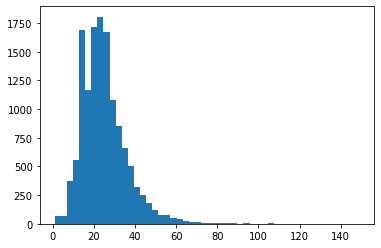

In [14]:
import matplotlib.pyplot as plt

train = split['train']['translation']
input_lens = [len(tr['modern']) for tr in train]

plt.hist(input_lens, bins=50); # in order to see the maximum length for truncation

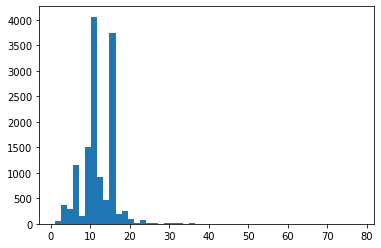

In [15]:
target_lens = [len(tr['ancient']) for tr in train]
plt.hist(target_lens, bins=50);

In [16]:
max_input_len = 128
max_target_len = 64

def tokenizer_fn(batch):
  inputs = [x['modern'] for x in batch['translation']]
  targets = [x['ancient'] for x in batch['translation']]

  tokenized_inputs = tokenizer(
    inputs, max_length=max_input_len, truncation=True)

  tokenized_targets = tokenizer(
    targets, max_length=max_target_len, truncation=True)
  
  tokenized_inputs['labels'] = tokenized_targets['input_ids']
  return tokenized_inputs

In [17]:
tokenized_datasets = split.map(
    tokenizer_fn,
    batched=True,
    remove_columns=split['train'].column_names,
)

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [18]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 13445
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 4482
    })
})

## Metric and Model Settings

In [19]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/790M [00:00<?, ?B/s]

In [20]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [21]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(1, 3)])
batch.keys() 
# deta_collator needs the inputs to be a list of dict, each dict contains the info of a sample. so if we directly pass 
# tokenized_datasets["train"][1:3], as the previous 2 blocks shows, it won't fit the format.

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [22]:
!pip install bert-score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60 kB 6.6 MB/s 


In [23]:
from datasets import load_metric

bert_metric = load_metric("bertscore")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
# test metric compute
bert_metric.compute(
    predictions=["常恐零露降"], references=[["常常担心寒冷的露珠降临"]], lang='zh') # need to specify language for bert score

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/412M [00:00<?, ?B/s]

{'precision': [0.6533329486846924],
 'recall': [0.6154574751853943],
 'f1': [0.6338298916816711],
 'hashcode': 'bert-base-chinese_L8_no-idf_version=0.3.11(hug_trans=4.23.1)'}

In [25]:
import numpy as np

def compute_metrics(preds_and_labels):
  # preds are not logits, but token ids
  preds, labels = preds_and_labels
  print(preds)

  # convert predictions into words
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

  # for any -100 label, replace with pad token id
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

  # convert labels into words
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # get rid of extraneous whitespace
  # and also, put targets into lists
  decoded_preds = [pred.strip() for pred in decoded_preds]
  decoded_labels = [[label.strip()] for label in decoded_labels]

  bert_score = bert_metric.compute(
      predictions=decoded_preds, references=decoded_labels, lang='zh')

  return {'bert_score': np.mean(bert_score['f1'])}

In [26]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
  "finetuned-model",
  evaluation_strategy="no",
  save_strategy="epoch",
  learning_rate=2e-5,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=64,
  weight_decay=0.01,
  save_total_limit=3,
  num_train_epochs=6,
  predict_with_generate=True,
  fp16=True,
)

In [27]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Using cuda_amp half precision backend


## Train and Evaluation

In [28]:
# check metrics before start training
trainer.evaluate(max_length=max_target_len)

The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4482
  Batch size = 64


[[ 101 8020  852 ...  102  102    0]
 [ 101 1333 3341 ...  102  102    0]
 [ 101 6898 3307 ...  102  102    0]
 ...
 [ 101 1870  691 ...  102  102    0]
 [ 101 3125  782 ... 1923 1923    0]
 [ 101 3300 3198 ...  102  102    0]]


{'eval_loss': 8.840609550476074,
 'eval_bert_score': 0.6219112799934701,
 'eval_runtime': 80.8467,
 'eval_samples_per_second': 55.438,
 'eval_steps_per_second': 0.878}

In [29]:
# may run out of gpu memory - try to restart runtime
# or get a more powerful gpu!
trainer.train()

The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 13445
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2526


Step,Training Loss
500,4.657300
1000,4.076600
1500,3.880700
2000,3.731000
2500,3.652700


Saving model checkpoint to finetuned-model/checkpoint-421
Configuration saved in finetuned-model/checkpoint-421/config.json
Model weights saved in finetuned-model/checkpoint-421/pytorch_model.bin
tokenizer config file saved in finetuned-model/checkpoint-421/tokenizer_config.json
Special tokens file saved in finetuned-model/checkpoint-421/special_tokens_map.json
Saving model checkpoint to finetuned-model/checkpoint-842
Configuration saved in finetuned-model/checkpoint-842/config.json
Model weights saved in finetuned-model/checkpoint-842/pytorch_model.bin
tokenizer config file saved in finetuned-model/checkpoint-842/tokenizer_config.json
Special tokens file saved in finetuned-model/checkpoint-842/special_tokens_map.json
Saving model checkpoint to finetuned-model/checkpoint-1263
Configuration saved in finetuned-model/checkpoint-1263/config.json
Model weights saved in finetuned-model/checkpoint-1263/pytorch_model.bin
tokenizer config file saved in finetuned-model/checkpoint-1263/tokenizer_

TrainOutput(global_step=2526, training_loss=3.9955322193136693, metrics={'train_runtime': 598.1335, 'train_samples_per_second': 134.87, 'train_steps_per_second': 4.223, 'total_flos': 5042951469987840.0, 'train_loss': 3.9955322193136693, 'epoch': 6.0})

In [30]:
# check the metrics after training
trainer.evaluate(max_length=max_target_len)

The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4482
  Batch size = 64


[[ 101  101 3217 ...  102  102    0]
 [ 101  101  671 ... 1062 1062    0]
 [ 101  101 1298 ...  102  102    0]
 ...
 [ 101  101 1870 ...  102  102    0]
 [ 101  101 3125 ...  102  102    0]
 [ 101  101 2255 ...  102  102    0]]


{'eval_loss': 3.6200594902038574,
 'eval_bert_score': 0.6911433789611447,
 'eval_runtime': 73.7802,
 'eval_samples_per_second': 60.748,
 'eval_steps_per_second': 0.962,
 'epoch': 6.0}

## Save, load and use model

In [31]:
trainer.save_model("Chinese_Poem_Translation_BartBased")

Saving model checkpoint to Chinese_Poem_Translation_BartBased
Configuration saved in Chinese_Poem_Translation_BartBased/config.json
Model weights saved in Chinese_Poem_Translation_BartBased/pytorch_model.bin
tokenizer config file saved in Chinese_Poem_Translation_BartBased/tokenizer_config.json
Special tokens file saved in Chinese_Poem_Translation_BartBased/special_tokens_map.json


In [32]:
from transformers import pipeline
translator = pipeline("translation", model='Chinese_Poem_Translation_BartBased', device=0)

loading configuration file Chinese_Poem_Translation_BartBased/config.json
Model config BartConfig {
  "_name_or_path": "Chinese_Poem_Translation_BartBased",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "d_model": 960,
  "decoder_attention_heads": 15,
  "decoder_ffn_dim": 3840,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 6,
  "decoder_start_token_id": 101,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 15,
  "encoder_ffn_dim": 3840,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 6,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 1024,
  

In [33]:
# input_setences = ["我借此火得度一生的茫茫黑夜",\
#                   "千年后如若我再生于祖国的河岸",\
#                   "千年后我再次拥有中国的稻田和周天子的雪山",\
#                   "泥土中涌上的处处是夜之幻影",\
#                   "在低压的暗云下唱着单调的东流的水",\
#                   "它必须完成生命的长梦而非游戏中黄粱一梦",\
#                   "你的身体每时每刻都触摸着宇宙",\
#                   "那鸿雁要什么时候才能到",\
#                   "春天江上的潮水仿佛连接着海面",\
#                   "我的忧愁仿佛一江春天的潮水滚滚向东流去",\
#                   "我也愿将自己埋葬在四周高高的山上"]

input_setences = ["我借此火得度一生的茫茫黑夜, 在低压的暗云下唱着单调的东流的水",\
                  "千年后如若我再生于祖国的河岸, 千年后我再次拥有中国的稻田和周天子的雪山",\
                  "泥土中涌上的处处是夜之幻影",\
                  "它必须完成生命的长梦而非游戏中黄粱一梦, 你的身体每时每刻都触摸着宇宙",\
                  "那鸿雁要什么时候才能到, 春天江上的潮水仿佛连接着海面",\
                  "我的忧愁仿佛一江春天的潮水滚滚向东流去, 我也愿将自己埋葬在四周高高的山上"]
for s in input_setences:
    print(translator(s)[0]['translation_text'])

Your input_length: 32 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 37 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


借 此 火 度 一 生 夜 ， 低 云 唱 东 流 水
千 年 若 我 生 于 河 ， 千 年 有 稻 周 天 山


Your input_length: 36 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 28 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


泥 土 处 处 夜 ， 泥 土 处 处 夜 影
须 成 长 梦 非 游 戏 ， 身 体 每 时 触 宇 宙


Your input_length: 38 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


鸿 雁 何 时 到 ， 潮 接 潮 海 面
愁 一 江 春 潮 ， 愿 埋 四 周 高
